<h1 style="color: black; padding: 15px; display: table; text-align: center; 
           box-shadow: 5px 5px 10px rgba(0,0,0,0.3); width: fit-content; margin: auto;">
  <span style="background-color: #FF0B55; padding: 5px; border: 3px solid black; display: inline-block;">
  Audio Calsification By Naive Bayes Model
  </span>
</h1>


In [1]:
!pip install librosa


In [2]:
!pip install noisereduce


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from glob import glob
import librosa 
import librosa.display
import IPython.display as ipd
from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [4]:
audio_files = glob('/kaggle/input/ravdess-emotional-speech-audio/**/*.wav', recursive=True)

<div style="background-color: #FFDEDE; border: 2px solid #CF0F47; border-radius: 15px; color: black; padding: 20px; margin: 10px 0;">
  <h3>🎯 Dataset Overview</h3>

  <p>
    Purpose: The dataset contains emotional speech recordings. Each audio file represents a specific emotional expression spoken by an actor.
  </p>
  
  <p>
    Total Samples: 1,440 audio files (actors * emotions * repetitions).
  </p>

  <p>
    Audio Files: .wav format, each file is about 3 seconds long.
  </p>

  <p>
    Feature: Each audio file represents a speech sample (e.g., words or phrases) expressing different emotions.
  </p>

  <h4>📊 Number of Samples</h4>
  <p>
    The dataset consists of 1,440 audio samples.
  </p>
  
  <p>
    24 actors (12 male, 12 female).
  </p>

  <p>
    Each actor speaks 8 different emotions (neutral, calm, happy, sad, angry, fearful, disgust, surprised).
  </p>

  <p>
    Each emotion is repeated 2 times by each actor.
  </p>

  <p>
    So, the formula for total samples is: 
  </p>
  <pre style="background-color: #FF0B55; border: 2px solid darkslategray; border-radius: 8px; color: white; padding: 10px;">
24 actors × 8 emotions × 2 repetitions = 1,440 samples
  </pre>

  <h4>📊 Number of Features</h4>
  <p>
    The features are extracted from each .wav file, such as:
  </p>

  <ul>
    <li>MFCC (Mel Frequency Cepstral Coefficients).</li>
    <li>Chroma (based on harmonic and melodic content).</li>
    <li>Spectral contrast (difference in amplitude between peaks and valleys in a sound).</li>
    <li>Zero-crossing rate (rate at which the signal changes sign).</li>
    <li>Other audio features like RMS, spectral flatness, etc.</li>
  </ul>

  <p>
    Each file can have a different number of features, depending on the extraction method used (e.g., MFCCs often have 13 coefficients).
  </p>

  <h4>📊 Class Distribution (Emotion Labels)</h4>
  <p>
    The dataset contains 8 emotion classes:
  </p>
  <ul>
    <li>Neutral</li>
    <li>Calm</li>
    <li>Happy</li>
    <li>Sad</li>
    <li>Angry</li>
    <li>Fearful</li>
    <li>Disgust</li>
    <li>Surprised</li>
  </ul>

  <p>
    Each class (emotion) has an equal number of samples because each actor expresses each emotion twice. So, for each emotion class, there are:
  </p>
</div>


In [5]:
print(f"Number of audio files: {len(audio_files)}")

Number of audio files: 2880


In [6]:
ipd.Audio(audio_files[3])

In [7]:
y,sr=librosa.load(audio_files[3])
print(f'y:{y[:10]}')
print(f'shape y:{y.shape}')
print(f'sr:{sr}')

y:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
shape y:(80196,)
sr:22050


<h3 style="background-color: #FF0B55; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Visualization Step Before Preprocessing
</h3>


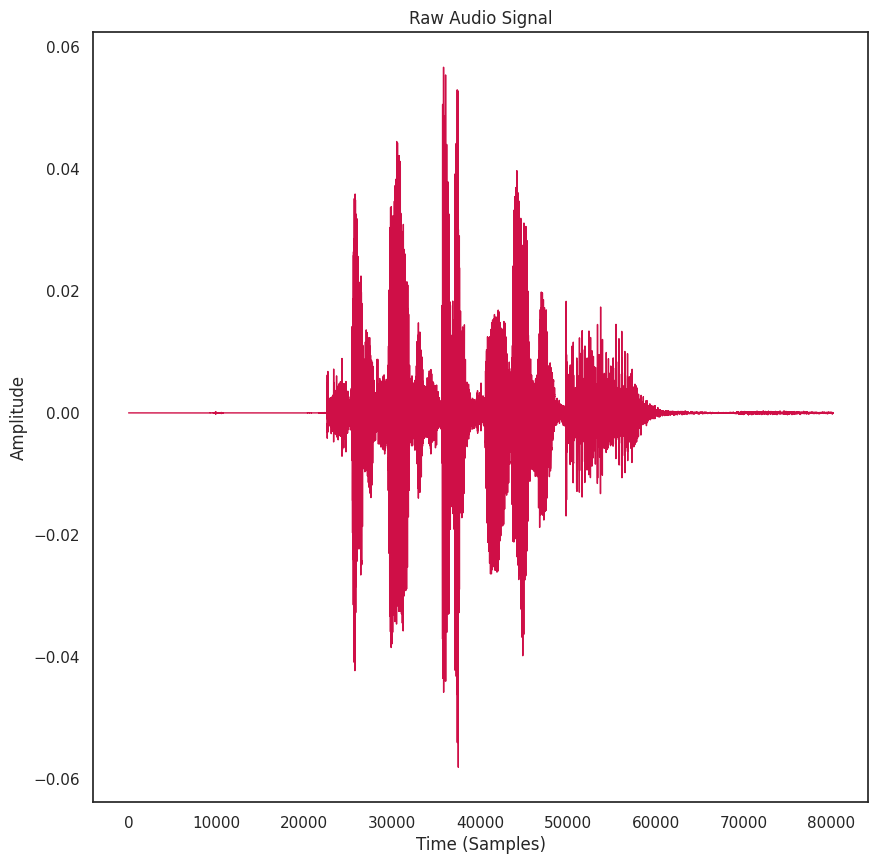

In [8]:
pd.Series(y).plot(figsize=(10, 10), title='Raw Audio Signal', lw=1, color='#CF0F47')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.show()

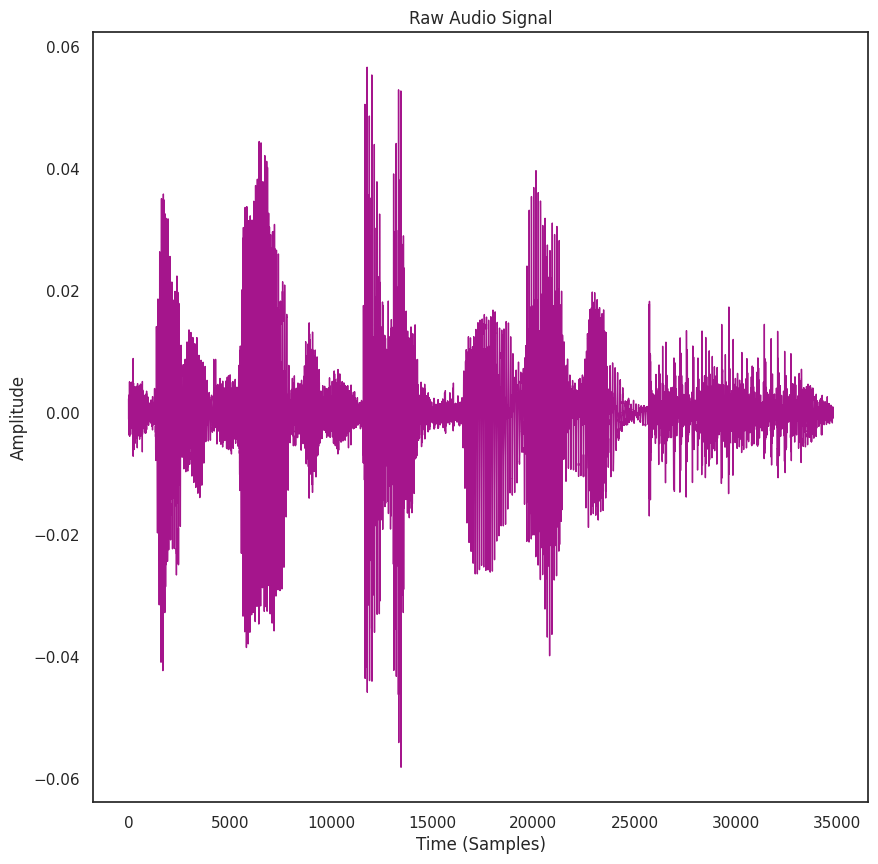

In [9]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 10), title='Raw Audio Signal', lw=1, color='#A5158C')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.show()

# Raw Zomed Example To Visualize

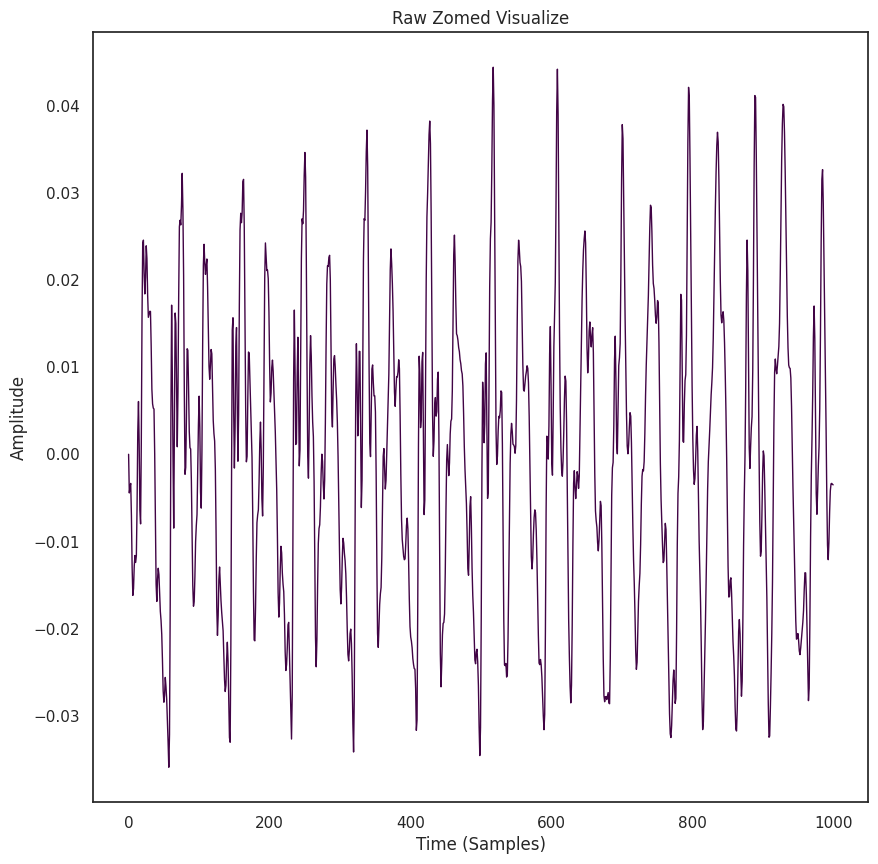

In [10]:
pd.Series(y[30000:31000]).plot(figsize=(10, 10), title='Raw Zomed Visualize', lw=1, color='#410445')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.show()

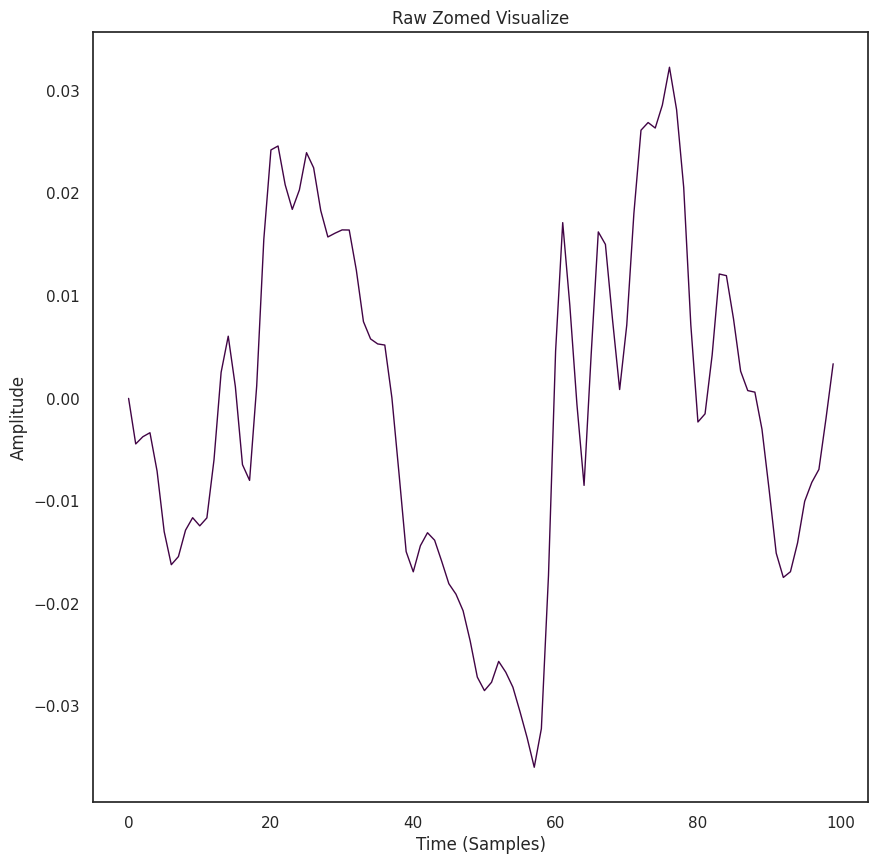

In [11]:
pd.Series(y[30000:30100]).plot(figsize=(10, 10), title='Raw Zomed Visualize', lw=1, color='#410445')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.show()

# Spectrogram

In [12]:
d=librosa.stft(y)
S_db=librosa.amplitude_to_db(np.abs(d),ref=np.max)
S_db.shape

(1025, 157)

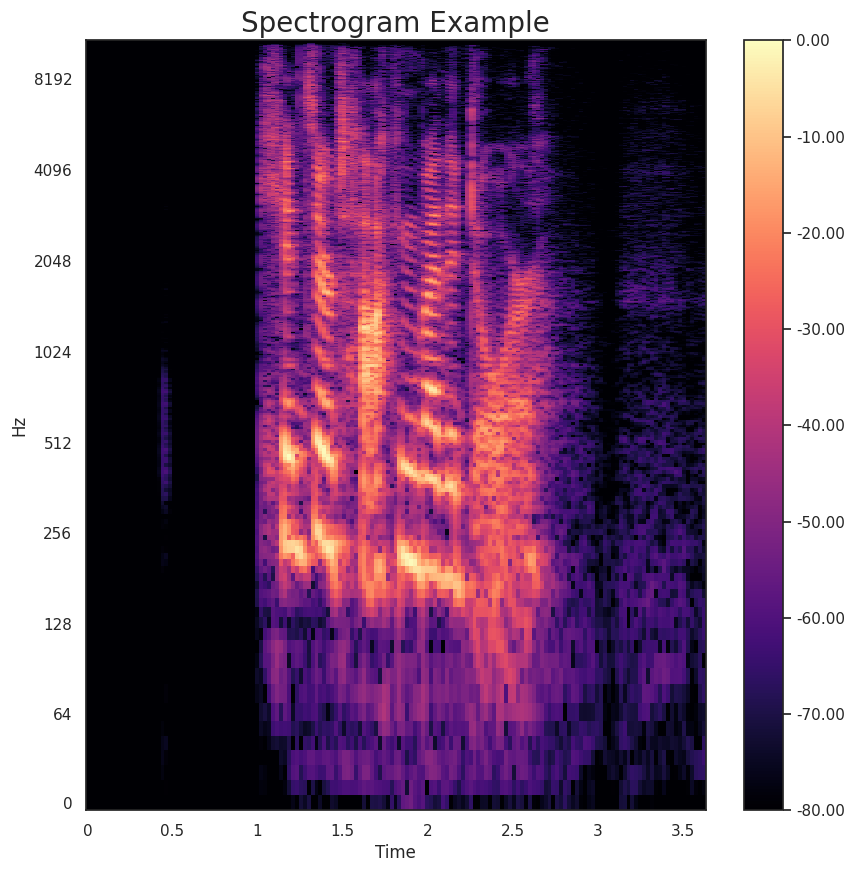

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
S = librosa.stft(y) 
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max) 
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spectrogram Example', fontsize=20)  
fig.colorbar(img, ax=ax, format='%0.2f')          
plt.show()

# Mel Spectrogram

In [14]:
import librosa
s = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=122)
print(s.shape)


(122, 157)


In [15]:
s_db_mel = librosa.amplitude_to_db(s, ref=np.max)

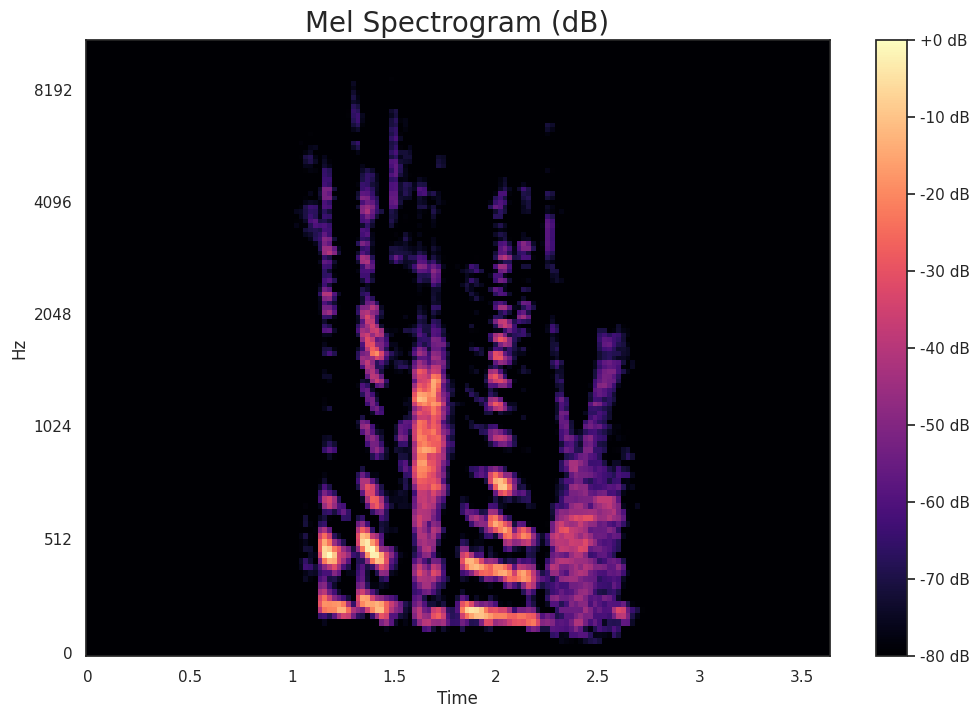

In [16]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(s_db_mel, x_axis='time', y_axis='mel', sr=sr, fmax=sr//2)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)', fontsize=20)
plt.show()

<h3 style="background-color: #FF0B55; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Preprocessing and Feature Extraction
</h3>


<h5 style="background-color: #FF0B55; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Perform data preprocessing steps
</h5>


<h6 style="background-color: #FF2DF1; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Noise reduction
</h6>


In [17]:
import noisereduce as nr

In [18]:
noise_reduced_audios = []
for file in audio_files:
    y, sr = librosa.load(file, sr=None)
    reduced_noise = nr.reduce_noise(y=y, sr=sr)
    noise_reduced_audios.append((reduced_noise, sr))
print(f"Noise Reduction Done! Total files: {len(noise_reduced_audios)}")

Noise Reduction Done! Total files: 2880


<h6 style="background-color: #FF2DF1; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
   Silence removal 
</h6>


In [19]:
silence_removed_audios = []
for reduced_noise, sr in noise_reduced_audios:
    intervals = librosa.effects.split(reduced_noise, top_db=20)  # Silence threshold
    non_silent_audio = np.concatenate([reduced_noise[start:end] for start, end in intervals])
    silence_removed_audios.append((non_silent_audio, sr))
print(f"Silence Removal Done! Total files: {len(silence_removed_audios)}")

Silence Removal Done! Total files: 2880


  <h6 style="background-color: #FF2DF1; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Normalization 
</h6>


In [20]:
normalized_audios = []
for audio, sr in silence_removed_audios:
    if np.max(np.abs(audio)) != 0:
        normalized_audio = audio / np.max(np.abs(audio)) 
    else:
        normalized_audio = audio 
    normalized_audios.append((normalized_audio, sr))
print(f"Normalization Done! Total files: {len(normalized_audios)}")

Normalization Done! Total files: 2880


 <h5 style="background-color: #FF0B55; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
 Extract relevant features from the speech signals
</h5>


<h6 style="background-color: #FF2DF1; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Mel-Frequency Cepstral Coefficients (MFCCs)
</h6>


<h6 style="background-color: #FF2DF1; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Spectral features (e.g., Spectral Centroid, Spectral Rolloff)  
</h6>


<h6 style="background-color: #FF2DF1; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Zero-Crossing Rate 
</h6>


<h6 style="background-color: #FF2DF1; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Root Mean Square Energy (RMSE)
</h6>

In [21]:
features = []
for audio, sr in normalized_audios:
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    spec_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spec_centroid_mean = np.mean(spec_centroid)

    spec_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    spec_rolloff_mean = np.mean(spec_rolloff)

    zcr = librosa.feature.zero_crossing_rate(audio)
    zcr_mean = np.mean(zcr)

    rmse = librosa.feature.rms(y=audio)
    rmse_mean = np.mean(rmse)

    feature_vector = np.hstack([
        mfccs_mean,              
        [spec_centroid_mean],   
        [spec_rolloff_mean],     
        [zcr_mean],              
        [rmse_mean]              
    ])
    features.append(feature_vector)


In [22]:
print(f"Example feature vector shape: {features[0].shape}")
print(f"Example feature vector: {features[0]}")

Example feature vector shape: (17,)
Example feature vector: [-3.07419128e+02  1.00580704e+02 -2.21906643e+01  7.33822012e+00
 -7.43646324e-01 -9.02012730e+00 -3.16807060e+01 -2.20693588e+00
 -1.65341721e+01 -7.36215258e+00 -8.91644764e+00 -1.42204380e+01
 -1.31691799e+01  3.14582317e+03  5.46584821e+03  7.59021577e-02
  9.74204913e-02]


<h3 style="background-color: #FF0B55; border: 2px solid black; color: black; display: inline-block; padding: 10px; text-align: left; margin: 0;">
  Visualization Step After Preprocessing 
</h3>


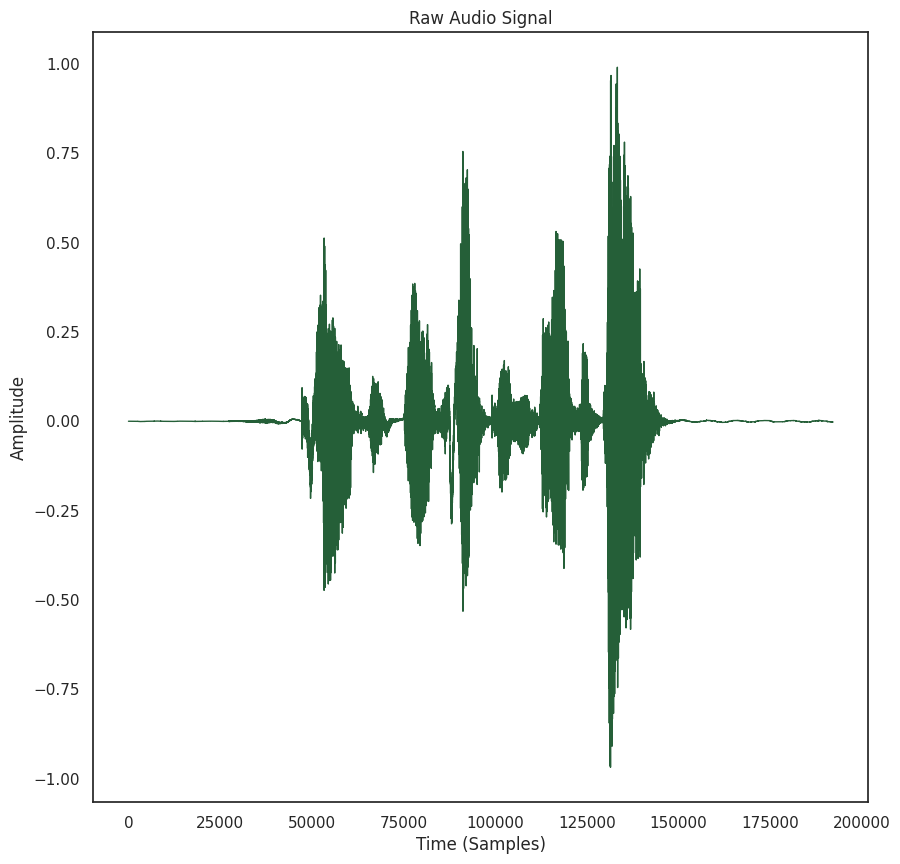

In [23]:
pd.Series(y).plot(figsize=(10, 10), title='Raw Audio Signal', lw=1, color='#255F38')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.show()

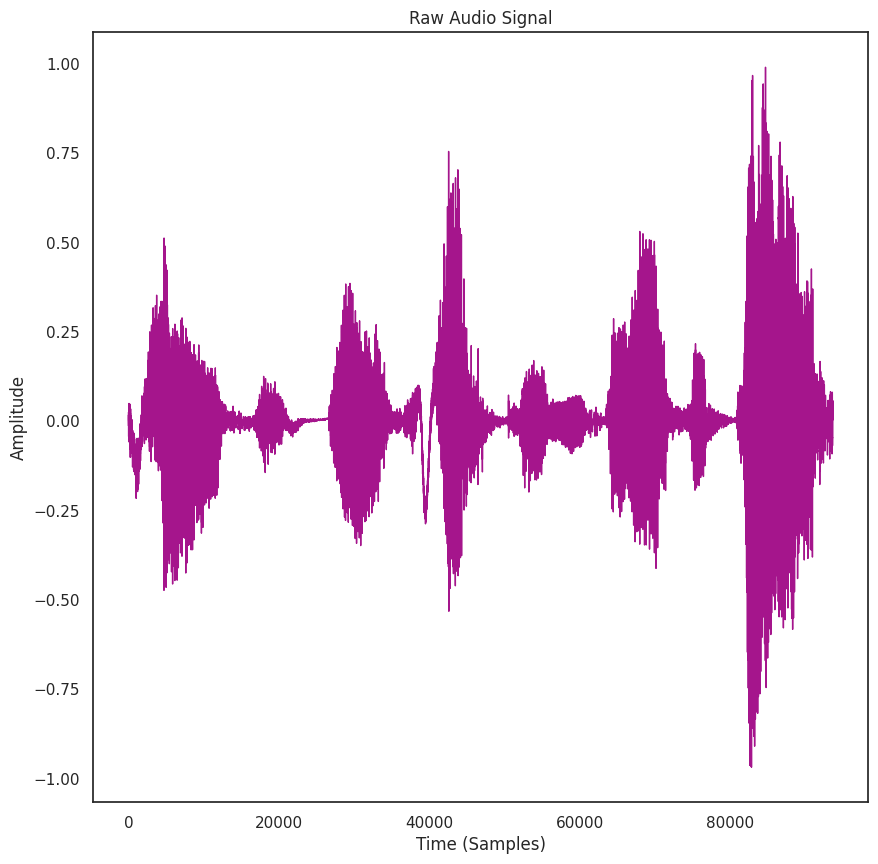

In [24]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 10), title='Raw Audio Signal', lw=1, color='#A5158C')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.show()

# Raw Zomed Example To Visualize

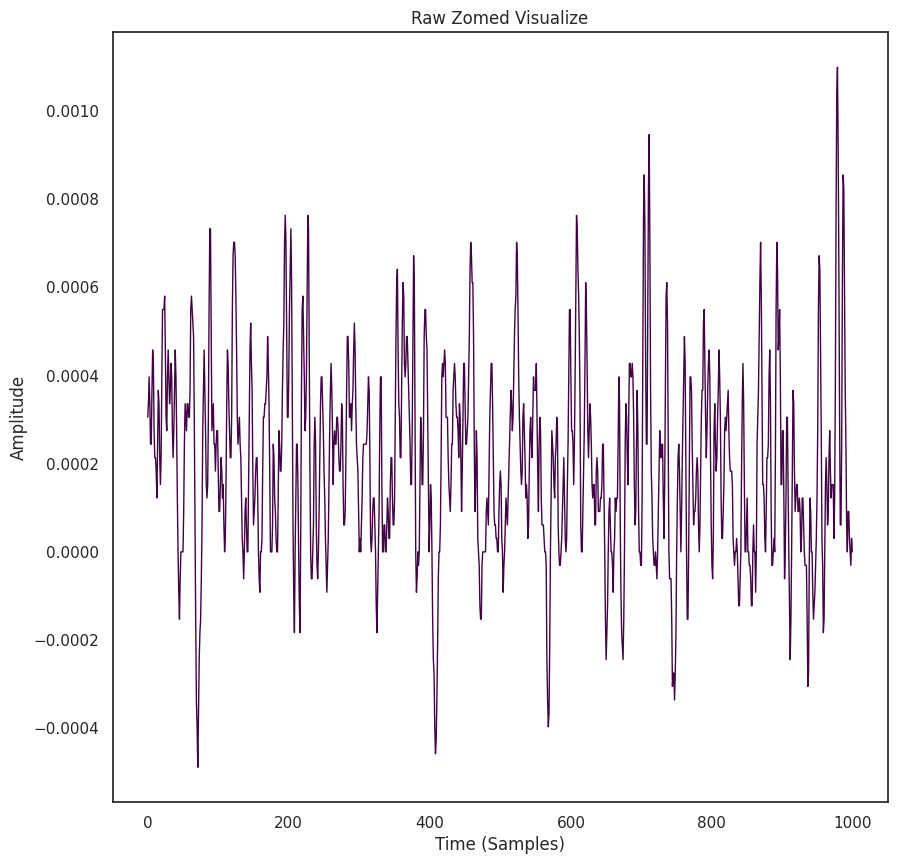

In [25]:
pd.Series(y[30000:31000]).plot(figsize=(10, 10), title='Raw Zomed Visualize', lw=1, color='#410445')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.show()

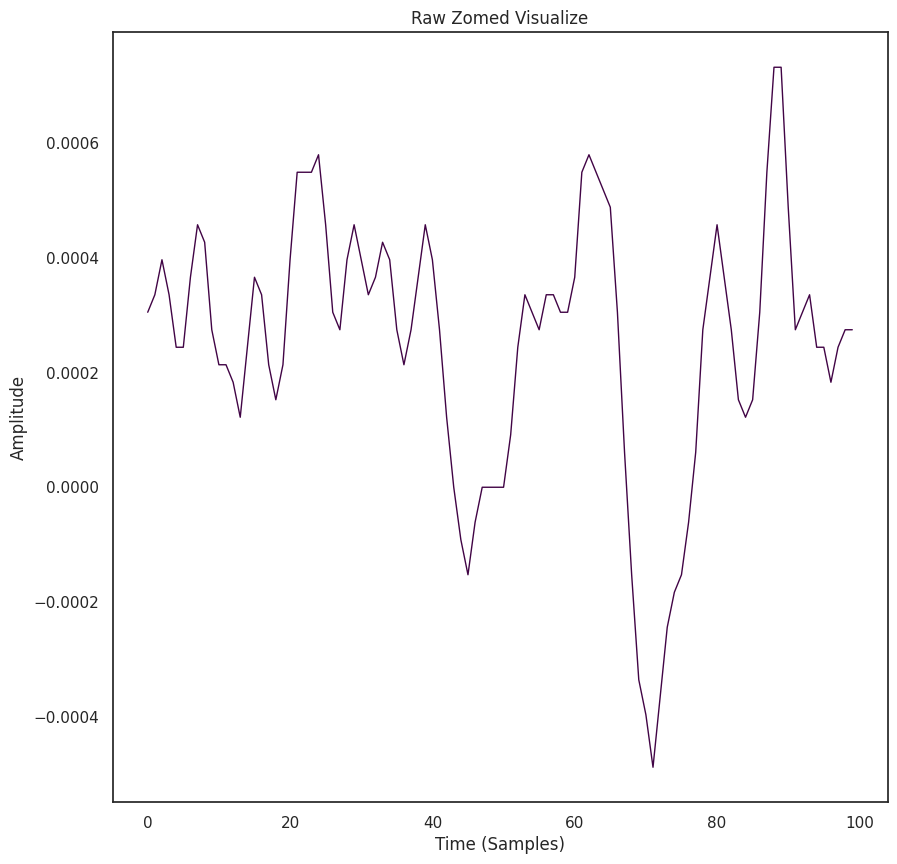

In [26]:
pd.Series(y[30000:30100]).plot(figsize=(10, 10), title='Raw Zomed Visualize', lw=1, color='#410445')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.show()

# Spectrogram

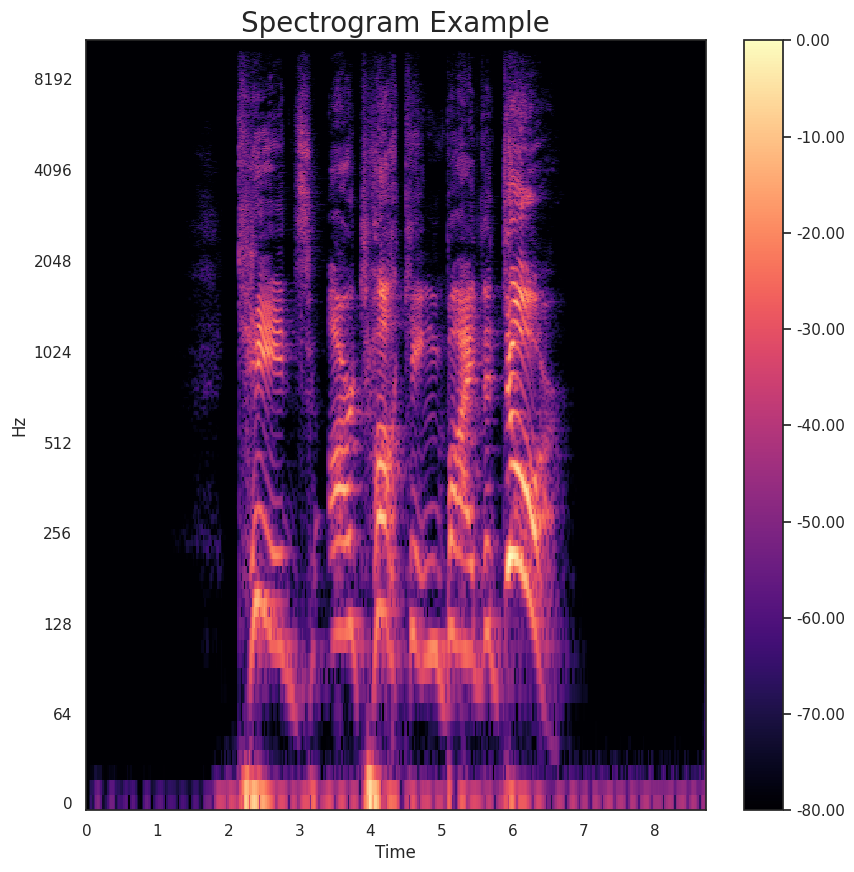

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
S = librosa.stft(y) 
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max) 
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spectrogram Example', fontsize=20)  
fig.colorbar(img, ax=ax, format='%0.2f')          
plt.show()

# Mel Spectrogram

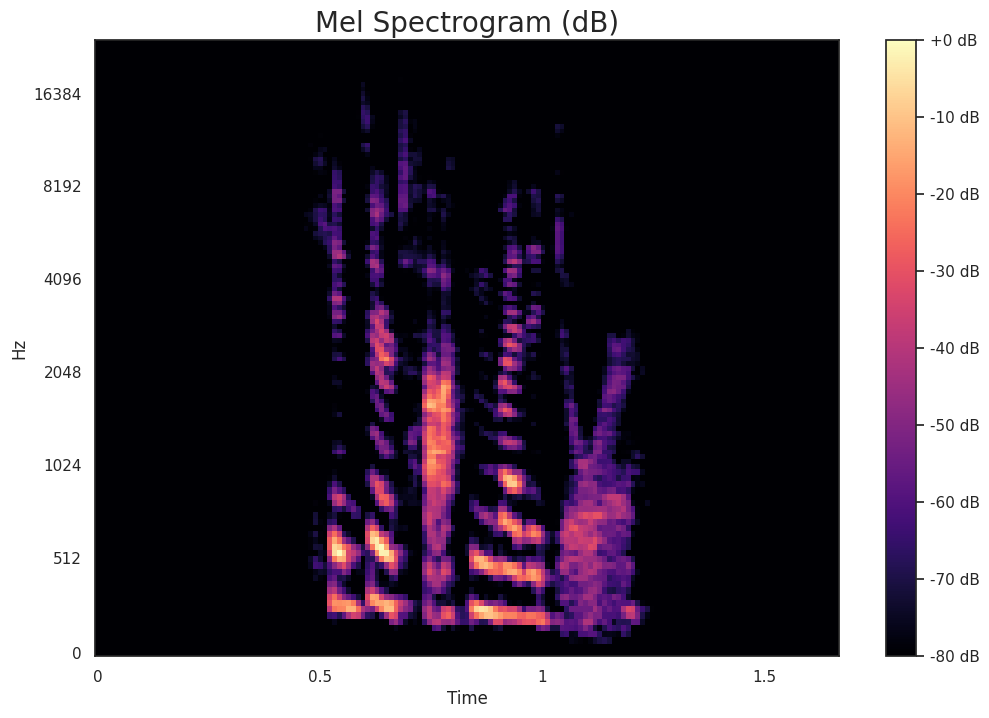

In [28]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(s_db_mel, x_axis='time', y_axis='mel', sr=sr, fmax=sr//2)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)', fontsize=20)
plt.show()